In [280]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

In [97]:
drive_dir = "/Volumes/Brain2024"
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=drive_dir, use_static_cache=True)
behavior_sessions = cache.get_behavior_session_table()

Now, we want to integrate information from below few stages:
- training 3
- training 4
- training 5 ready, lapsed, epilogue.

In the end, hopefully we can include the ephys sessions.

The `strategy_summary.csv`s will be of less number of rows, compared to the total sessions. Better write a function combining them.

In [98]:
strategy_df_3 = pd.read_csv('local_modelfit/training3/strategy_summary.csv', index_col = 0)
sessions_3 =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_3')) & 
                                (behavior_sessions.genotype == 'wt/wt')]

strategy_df_4 = pd.read_csv('local_modelfit/training4/strategy_summary.csv', index_col = 0)
sessions_4 =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_4')) & 
                                (behavior_sessions.genotype == 'wt/wt')]

strategy_df_5_epi = pd.read_csv('local_modelfit/training5/strategy_summary_epilogue.csv', index_col = 0)
sessions_5_epi =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_5')) & 
                                    (behavior_sessions.session_type.str.contains('epilogue')) & 
                                    (behavior_sessions.genotype == 'wt/wt')]

strategy_df_5_lps = pd.read_csv('local_modelfit/training5/strategy_summary_lapsed.csv', index_col = 0)
sessions_5_lps =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_5')) & 
                                    (behavior_sessions.session_type.str.contains('lapsed')) & 
                                    (behavior_sessions.genotype == 'wt/wt')]

strategy_df_5_rdy = pd.read_csv('local_modelfit/training5/strategy_summary.csv', index_col = 0)
sessions_5_rdy =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_5')) & 
                                    (behavior_sessions.session_type.str.contains('ready')) & 
                                    (behavior_sessions.genotype == 'wt/wt')]

In [99]:
sessions_5_epi =  behavior_sessions[
                                    (behavior_sessions.session_type.str.contains('epilogue')) & 
                                    (behavior_sessions.genotype == 'wt/wt')]

In [100]:
strategy_df_5_epi

,auc,evd,visual_index,timing_index,strategy_index
1034887215,0.779329,-1723.660502,3.229994,4.211440,-0.981445
1034659380,0.829364,-1339.459006,5.268902,3.375076,1.893827
1035085134,0.852031,-1199.044286,4.195976,8.616457,-4.420481
1032395078,0.804281,-1164.172484,6.306959,3.336257,2.970702
1033405814,0.772088,-1080.203274,6.399220,5.038890,1.360330
...,...,...,...,...,...
1117817318,0.845802,-801.905425,15.958907,3.647767,12.311140
1118300323,0.822027,-1098.441076,8.718290,8.384041,0.334249
1118496195,0.873466,-909.145550,18.617071,9.782198,8.834873
1124668180,0.887778,-643.823003,38.274979,5.588691,32.686288


In [101]:
len(strategy_df_5_epi)

174

In [187]:
import pandas as pd

def merge_strategy_with_sessions(strategy_df, sessions, stage ):
    """
    Merge strategy_df with selected columns from sessions DataFrame based on index,
    keeping only the rows where the index appears in both DataFrames.
    
    Parameters:
    strategy_df (pd.DataFrame): The strategy DataFrame
    sessions (pd.DataFrame): The sessions DataFrame containing 'mouse_id' and 'session_number'
    
    Returns:
    pd.DataFrame: Merged DataFrame
    """
    sessions_subset = sessions[['mouse_id', 'session_number']]
    
    strategy_df.index.name = sessions_subset.index.name
    
    # Merge the DataFrames on index, using an inner join, as there are some repeats in strategy_df, and some not included from sessions_subset
    merged_df = pd.merge(strategy_df, sessions_subset, left_index=True, right_index=True, how='inner')
    
    merged_df['stage'] = stage
    merged_df['behavior_session_id'] = merged_df.index

    print(f"Original strategy_df shape: {strategy_df.shape}")
    print(f"Original sessions shape: {sessions.shape}")
    print(f"Merged DataFrame shape: {merged_df.shape}")
    print(f"Number of rows dropped: {strategy_df.shape[0] - merged_df.shape[0]}")
    
    return merged_df


In [188]:
srategy_df_3_merged = merge_strategy_with_sessions(strategy_df_3, sessions_3, "3")
srategy_df_4_merged = merge_strategy_with_sessions(strategy_df_4, sessions_4, "4")
srategy_df_5_epi_merged = merge_strategy_with_sessions(strategy_df_5_epi, sessions_5_epi, "5_epi")
srategy_df_5_lps_merged = merge_strategy_with_sessions(strategy_df_5_lps, sessions_5_lps, "5_lapsed")
srategy_df_5_rdy_merged = merge_strategy_with_sessions(strategy_df_5_rdy, sessions_5_rdy, "5_ready")

Original strategy_df shape: (82, 5)
Original sessions shape: (82, 14)
Merged DataFrame shape: (82, 9)
Number of rows dropped: 0
Original strategy_df shape: (50, 5)
Original sessions shape: (51, 14)
Merged DataFrame shape: (50, 9)
Number of rows dropped: 0
Original strategy_df shape: (174, 5)
Original sessions shape: (93, 14)
Merged DataFrame shape: (92, 9)
Number of rows dropped: 82
Original strategy_df shape: (72, 5)
Original sessions shape: (74, 14)
Merged DataFrame shape: (72, 9)
Number of rows dropped: 0
Original strategy_df shape: (218, 5)
Original sessions shape: (222, 14)
Merged DataFrame shape: (218, 9)
Number of rows dropped: 0


In [189]:
training_df = pd.concat([srategy_df_3_merged, srategy_df_4_merged, srategy_df_5_epi_merged, srategy_df_5_lps_merged, srategy_df_5_rdy_merged], 
                        axis=0, 
                        ignore_index=True)

#### Enrich the information with other session metrics: 

- `earned_reward_count` (directly from performance metrics)

- `false_alarm_trial_count` (directly from performance metrics)

- `max_dprime` (directly from performance metrics)

- `aborted`: which is the total number of aborted trials 

In [194]:
rewards = []
aborted = []
false_alarms = []
max_dprimes = []

for bsid in training_df.behavior_session_id:
    print('\n Processing:', bsid)
    behavior_session = cache.get_behavior_session(bsid)
    performace_metrics = behavior_session.get_performance_metrics()
    rewards.append(performace_metrics['earned_reward_count'])
    false_alarms.append(performace_metrics['false_alarm_trial_count'])
    max_dprimes.append(performace_metrics['max_dprime'])
    aborted.append(np.sum(behavior_session.trials['aborted']))



 Processing: 1034887215


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1034659380


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1035085134


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1032395078


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1033405814


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1033613829


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1033160344


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1042352531


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1042590922


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1042847275


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1043758309


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1044600724


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1044996732


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1050926946


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1051130808


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1051338427


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1055609811


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1056281961


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1056115005


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1057606556


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1057886878


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1058174378


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1058698214


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059229994


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059472936


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059468092


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1058692080


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059233617


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1058692082


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059468094


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059234095


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061695378


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062313505


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061474921


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062327095


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061722976


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061505394


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1069671000


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1070957226


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1070619080


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1072354762


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1072577074


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074495186


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1072339169


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1072547384


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074477976


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074477981


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074920488


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074670616


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1072145766


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1072339697


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074481734


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1094656577


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1094100826


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1095128738


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1092626068


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1093153433


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1093379122


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1098609458


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1099181430


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1098385687


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101080541


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101322871


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1100793165


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1111249595


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1111426400


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1112117024


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1111427544


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1112338074


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1112117022


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1113723874


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1113450532


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1113937415


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1116896007


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1116697809


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1116433179


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1124236078


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1123789401


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1124031793


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125704043


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125254502


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125489477


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1035340292


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1033820752


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1043159265


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1045550754


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1051860415


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1057894268


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1056739437


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1056520886


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1057020839


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1057629370


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1058146470


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1058478659


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061209141


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059677668


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059883560


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061654232


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060634278


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060849686


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060077153


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061427805


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059650171


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059650175


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062575917


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1071656322


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1071265695


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074701715


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074651250


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075103608


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074684539


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074925781


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075097616


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1095337546


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1093583546


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1099418970


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101501551


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1112338076


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1112785852


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1113534486


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1112552076


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1113793504


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1116468776


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1114162717


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1114738525


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1115253955


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1115010665


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1115619937


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1115879271


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1117113728


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1124457104


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125919448


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1036855550


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1037466182


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1035976487


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1036434296


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1036629839


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1034508317


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1044629197


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1043774368


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1047772100


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1046638304


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1047535739


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1048001337


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1046925699


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1045904194


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1046247654


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1052305334


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1052104716


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1058467160


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059254645


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1058751471


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063891105


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062731320


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062951905


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063206219


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062500414


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062276047


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060056254


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059870997


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060986134


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060057412


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059871751


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062315484


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060682754


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061705670


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061475490


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061253433


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062764924


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063029430


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064892531


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063068159


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062776994


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063926995


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064436633


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064168758


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064660686


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1065492447


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1065933287


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1072144342


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075127005


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075366965


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074949176


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074898303


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076627836


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075271140


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075832261


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075092390


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076041658


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076244439


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076418744


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075283418


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075846795


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075280303


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075847947


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1095601600


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1094645370


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1094072049


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1095094404


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1093805166


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1095303170


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1095554374


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1096231548


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1099899552


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1100176590


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1099623073


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1102211933


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1102929924


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1102421273


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1102608356


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1112554800


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1113986711


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1114814628


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1114219288


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1115366633


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1115088169


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1116715909


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1118060536


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1117297173


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1117817318


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1118300323


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1118496195


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1124668180


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1126117235


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1051166160


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1052337558


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1050964920


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1046591046


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1048008824


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1050286728


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1052533824


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1051369434


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1049087721


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1049284828


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1046217735


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1048418461


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1045875451


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1046902362


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1047551353


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1047776813


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1048219493


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1049519521


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1049769442


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1050664123


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1050311775


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1049536543


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1049778048


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1065476199


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064649117


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064412813


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064856447


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1065921390


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063915396


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064412809


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074898315


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076280175


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1078089225


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1077486812


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076654236


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1077693265


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1077871356


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076464988


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101292767


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101059942


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101491532


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125697218


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125501444


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1120522810


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1120307810


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1123093694


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1123279081


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1124052250


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1124273004


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1124483393


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125260357


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1124677155


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1129048947


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1135107017


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1131651767


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1127440350


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1129644205


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1134093278


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1128009932


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1131497514


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1128230936


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1128496433


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1128706822


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1129839807


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1130346783


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1131794350


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1132234194


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1132878595


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1133612875


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1133879512


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1134322824


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1134858949


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1039510310


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1038110210


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1038770408


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1037729598


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1037924499


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1039002886


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1039252665


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1039801382


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1038281631


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1045879825


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1036676883


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1047524271


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1041508951


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1036466580


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1042816424


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1039289496


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1040461526


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1041104649


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1046616561


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1046206826


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1040856429


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1044603838


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1047756186


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1045537414


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1046909888


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1047981342


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1048211091


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1048419485


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1034738114


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1034922464


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1035133698


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1035451613


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1036060994


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1036279767


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1036942496


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1037514584


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1037761417


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1037948176


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1038133272


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1038797373


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1039830590


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1041296481


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1042031031


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1042311455


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1042584677


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1043137923


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1043765740


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1044999641


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1052133518


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1052748814


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1051925537


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1045015223


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1045526825


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1050668465


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1048430639


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1051943283


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1051380286


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1049302025


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1049116555


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1050968995


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1051180953


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1052512677


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1052709911


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1058745864


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059663778


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060066304


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059870004


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1059506135


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064620203


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064134549


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064356330


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064797359


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060682758


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061696350


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1060986129


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061475492


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1061253437


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062560172


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1067366805


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1068088615


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1062764927


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064156024


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1066127488


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063027832


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063915394


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063280283


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1067027822


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1067603471


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1067795809


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1063280281


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064156022


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1064856453


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1067815988


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1067615228


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1067382321


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1067067458


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1066140821


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1068116062


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1072550205


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074654034


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1072340333


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1074471404


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075092388


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075272122


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1077723093


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076705594


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1077522309


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1075894873


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076084811


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1077907084


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076489424


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1078047231


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1077470034


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1077693261


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1077874329


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076643144


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076448964


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076261714


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076056040


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076269784


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1076056042


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1078042978


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1078577890


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1096255616


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1096957312


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1096483226


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1097187272


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1096713658


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1099410171


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1099653152


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1100769409


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1096469887


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1096671108


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1096944338


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1097717223


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1097172824


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1097949067


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1098133795


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1098597821


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1099900189


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101055123


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101290013


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1100201646


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101486794


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101698040


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1138834291


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1106050257


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1102183216


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1105583599


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1104098504


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1100782535


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1101689959


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1102390735


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1102605297


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1102811829


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1103020141


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1103559051


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1103821329


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1104302007


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1105106074


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1105303069


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1104547847


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1105823993


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1107006800


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1107373825


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1107186120


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1104116217


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1103636920


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1104567994


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1103848600


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1103053376


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1104326011


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1105124327


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1105319315


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1105606738


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1106089618


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1113535438


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1112788916


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1113985597


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1113795688


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1114219286


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1115944336


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1115679700


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1116938392


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1117129176


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1117314622


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1118822833


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1123827395


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1127239255


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1120022911


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1121648063


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1119807145


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1121051297


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1121449630


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1122679099


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1122897846


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1122463692


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1126112609


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125928022


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1127051728


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1126880443


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1127442707


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125257531


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125491643


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125706504


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1125921566


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1126115786


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1135551120


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1132591016


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1126881717


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1127063812


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1127250255


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1130545530


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1131311228


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1132435788


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1132744410


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1135345527


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)



 Processing: 1135831584


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [197]:
training_df['aborted'] = aborted
training_df['false_alarms'] = false_alarms
training_df['max_dprimes'] = max_dprimes
training_df['rewards'] = rewards


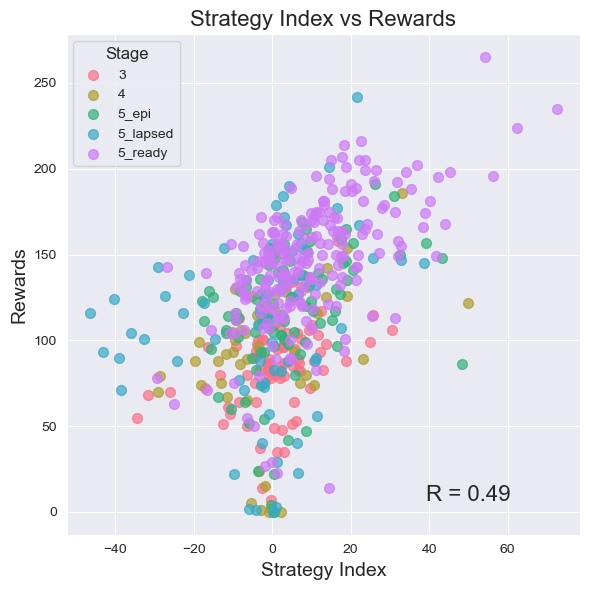

In [232]:
# Calculate correlation
r = np.corrcoef(training_df['rewards'], training_df['strategy_index'])

# Set up the plot
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 6))

# Create a color palette
unique_stages = training_df['stage'].unique()
color_palette = sns.color_palette("husl", n_colors=len(unique_stages))
color_dict = dict(zip(unique_stages, color_palette))

# Scatter plot with points colored by stage
for stage in unique_stages:
    stage_data = training_df[training_df['stage'] == stage]
    ax.scatter(x=stage_data.strategy_index, 
               y=stage_data.rewards, 
               c=[color_dict[stage]],
               label=stage,
               s=50, 
               alpha=0.7)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Rewards', fontsize=14)
ax.set_title('Strategy Index vs Rewards', fontsize=16)

# Add correlation text
ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')

# Add legend
ax.legend(title='Stage', title_fontsize=12, fontsize=10, loc='best')

plt.tight_layout()
plt.show()

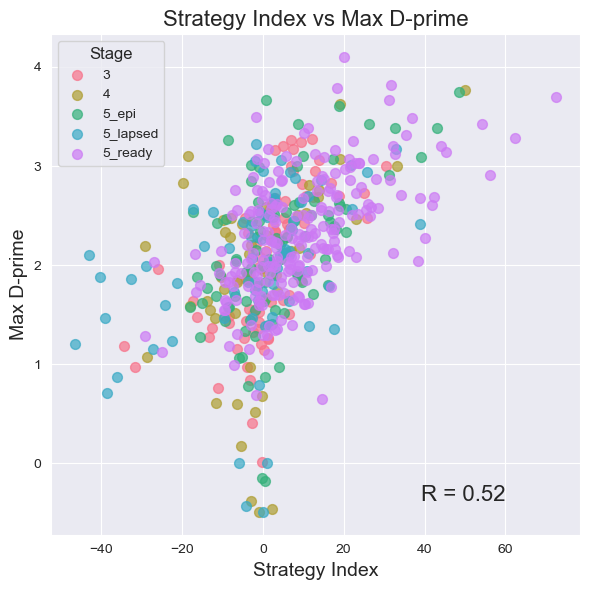

In [234]:
# Calculate correlation
r = np.corrcoef(training_df['max_dprimes'], training_df['strategy_index'])

# Set up the plot
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 6))

# Create a color palette
unique_stages = training_df['stage'].unique()
color_palette = sns.color_palette("husl", n_colors=len(unique_stages))
color_dict = dict(zip(unique_stages, color_palette))

# Scatter plot with points colored by stage
for stage in unique_stages:
    stage_data = training_df[training_df['stage'] == stage]
    ax.scatter(x=stage_data.strategy_index, 
               y=stage_data.max_dprimes, 
               c=[color_dict[stage]],
               label=stage,
               s=50, 
               alpha=0.7)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Max D-prime', fontsize=14)
ax.set_title('Strategy Index vs Max D-prime', fontsize=16)

# Add correlation text
ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')

# Add legend
ax.legend(title='Stage', title_fontsize=12, fontsize=10, loc='best')

plt.tight_layout()
plt.show()

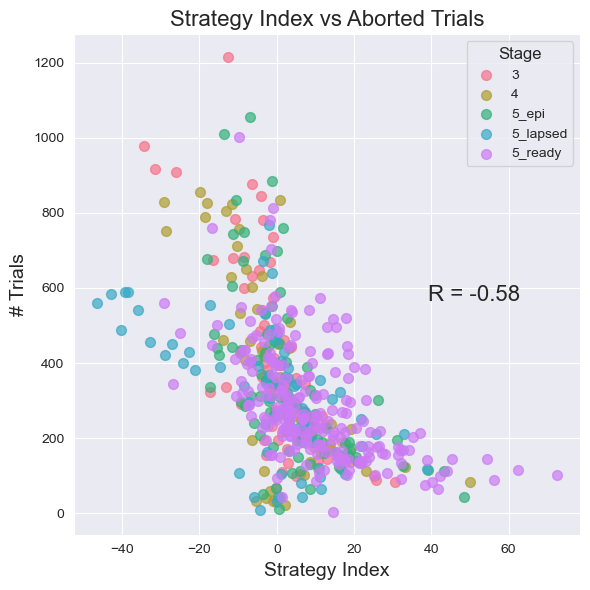

In [227]:
# Calculate correlation
r = np.corrcoef(training_df['aborted'], training_df['strategy_index'])

# Set up the plot
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 6))

# Create a color palette
unique_stages = training_df['stage'].unique()
color_palette = sns.color_palette("husl", n_colors=len(unique_stages))
color_dict = dict(zip(unique_stages, color_palette))

# Scatter plot with points colored by stage
for stage in unique_stages:
    stage_data = training_df[training_df['stage'] == stage]
    ax.scatter(x=stage_data.strategy_index, 
               y=stage_data.aborted, 
               c=[color_dict[stage]],
               label=stage,
               s=50, 
               alpha=0.7)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('# Trials', fontsize=14)
ax.set_title('Strategy Index vs Aborted Trials', fontsize=16)

# Add correlation text
ax.text(0.70, 0.50, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')

# Add legend
ax.legend(title='Stage', title_fontsize=12, fontsize=10, loc='best')

plt.tight_layout()
plt.show()

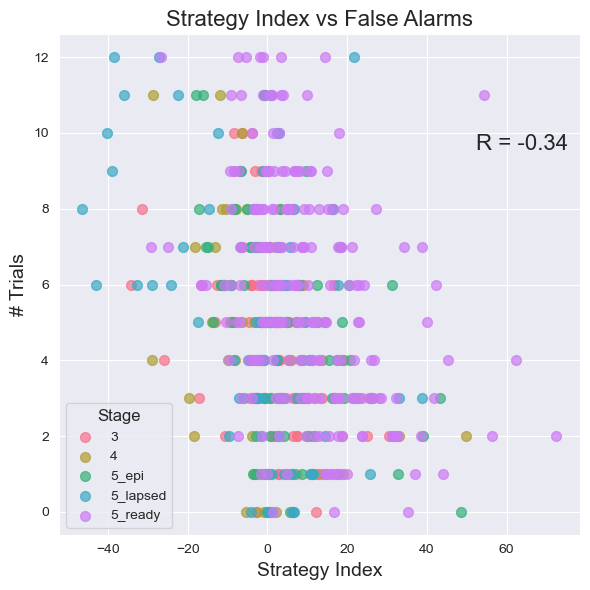

In [235]:
# Calculate correlation
r = np.corrcoef(training_df['false_alarms'], training_df['strategy_index'])

# Set up the plot
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 6))

# Create a color palette
unique_stages = training_df['stage'].unique()
color_palette = sns.color_palette("husl", n_colors=len(unique_stages))
color_dict = dict(zip(unique_stages, color_palette))

# Scatter plot with points colored by stage
for stage in unique_stages:
    stage_data = training_df[training_df['stage'] == stage]
    ax.scatter(x=stage_data.strategy_index, 
               y=stage_data.false_alarms, 
               c=[color_dict[stage]],
               label=stage,
               s=50, 
               alpha=0.7)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('# Trials', fontsize=14)
ax.set_title('Strategy Index vs False Alarms', fontsize=16)

# Add correlation text
ax.text(0.80, 0.80, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')

# Add legend
ax.legend(title='Stage', title_fontsize=12, fontsize=10, loc='best')

plt.tight_layout()
plt.show()

In [171]:
training_34_df = pd.concat([srategy_df_3_merged, srategy_df_4_merged], 
                        axis=0, 
                        ignore_index=True)


In [173]:
training_345_df = pd.concat([srategy_df_3_merged, srategy_df_4_merged, srategy_df_5_epi_merged], 
                        axis=0, 
                        ignore_index=True)

In [168]:
training_5_df = pd.concat([srategy_df_5_epi_merged, srategy_df_5_lps_merged, srategy_df_5_rdy_merged], 
                        axis=0, 
                        ignore_index=True)


In [177]:
training_5_post_df = pd.concat([srategy_df_5_lps_merged, srategy_df_5_rdy_merged], 
                        axis=0, 
                        ignore_index=True)

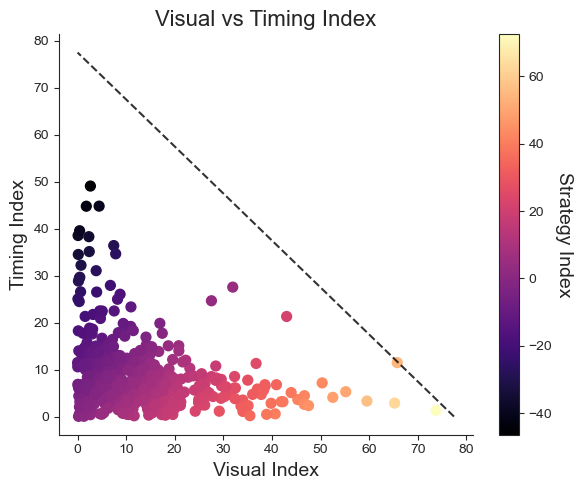

In [143]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_df.visual_index, 
                     y=training_df.timing_index, 
                     c=training_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Visual Index', fontsize=14)
ax.set_ylabel('Timing Index', fontsize=14)
ax.set_title('Visual vs Timing Index', fontsize=16)

max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([max_val, 0], [0, max_val], 'k--', alpha=0.8)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

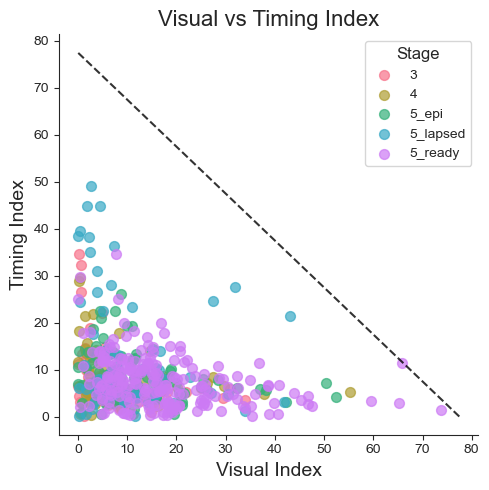

In [239]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5, 5))

# Create a color palette
unique_stages = training_df['stage'].unique()
color_palette = sns.color_palette("husl", n_colors=len(unique_stages))
color_dict = dict(zip(unique_stages, color_palette))

# Scatter plot with points colored by stage
for stage in unique_stages:
    stage_data = training_df[training_df['stage'] == stage]
    ax.scatter(x=stage_data.visual_index, 
               y=stage_data.timing_index, 
               c=[color_dict[stage]],
               label=stage,
               s=50, 
               alpha=0.7)

ax.set_xlabel('Visual Index', fontsize=14)
ax.set_ylabel('Timing Index', fontsize=14)
ax.set_title('Visual vs Timing Index', fontsize=16)

max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([max_val, 0], [0, max_val], 'k--', alpha=0.8)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
ax.legend(title='Stage', title_fontsize=12, fontsize=10, loc='best')

plt.tight_layout()
plt.show()

In [144]:
# Check if there are any NaN values in strategy_df
has_nan = training_df.isna().any().any()

if has_nan:
    print("strategy_df contains NaN values.")
    
    # Get columns with NaN values
    columns_with_nan = training_df.columns[training_df.isna().any()].tolist()
    print(f"Columns containing NaN values: {columns_with_nan}")
    
    # Get count of NaN values in each column
    nan_counts = training_df.isna().sum()
    print("\nCount of NaN values in each column:")
    print(nan_counts[nan_counts > 0])
    
    # Get rows with NaN values
    rows_with_nan = training_df.index[training_df.isna().any(axis=1)].tolist()
    print(f"\nIndices of rows containing NaN values: {rows_with_nan}")
    
    # Display a few rows with NaN as an example
    print("\nExample rows containing NaN values:")
    print(training_df[training_df.isna().any(axis=1)].head())
else:
    print("strategy_df does not contain any NaN values.")

strategy_df does not contain any NaN values.


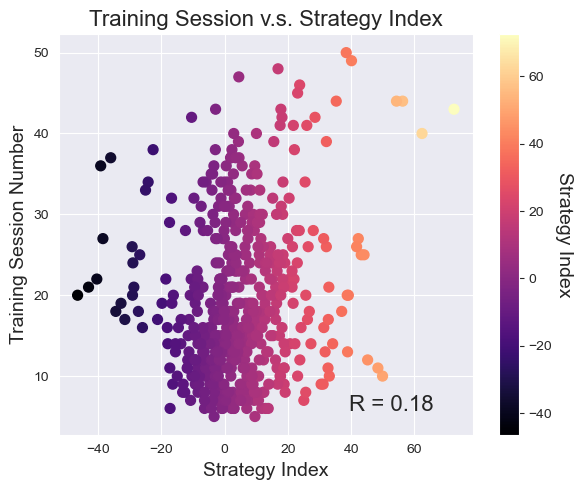

In [169]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_df['session_number'], training_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_df.strategy_index, 
                     y=training_df.session_number, 
                     c=training_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

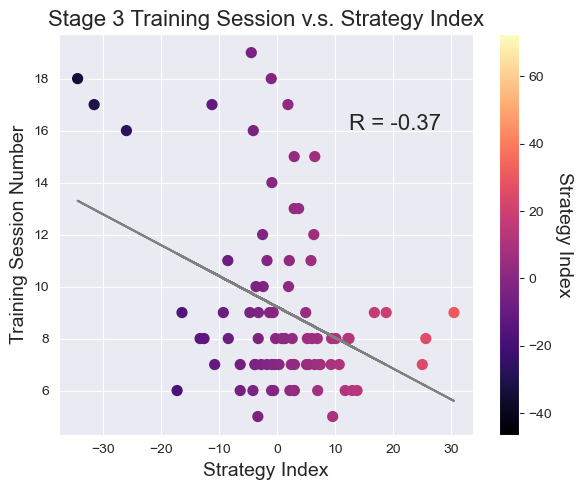

In [289]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(srategy_df_3_merged['session_number'], srategy_df_3_merged['strategy_index'])

norm = plt.Normalize(training_df['strategy_index'].min(), 
                     training_df['strategy_index'].max())

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=srategy_df_3_merged.strategy_index, 
                     y=srategy_df_3_merged.session_number, 
                     c=srategy_df_3_merged.strategy_index, 
                     cmap='magma', norm = norm, 
                     s=50, 
                     alpha=1) 


slope, intercept, r_value, p_value, std_err = stats.linregress(srategy_df_3_merged.strategy_index, srategy_df_3_merged.session_number)
line = slope * srategy_df_3_merged.strategy_index + intercept
ax.plot(srategy_df_3_merged.strategy_index, line, color='grey', linestyle='-', label='Regression Line')

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Stage 3 Training Session v.s. Strategy Index', fontsize=16)
ax.text(0.70, 0.80, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

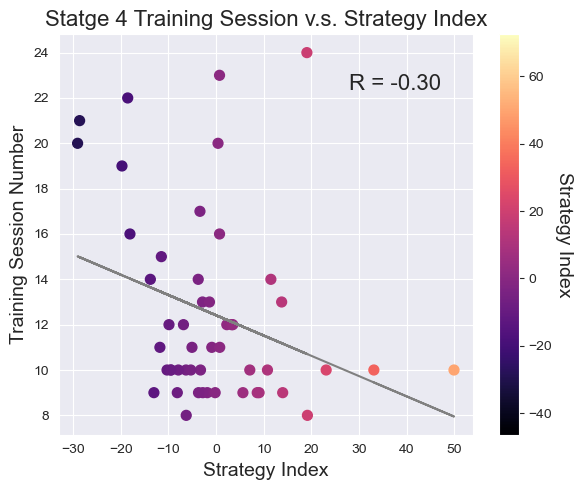

In [288]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(srategy_df_4_merged['session_number'], srategy_df_4_merged['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=srategy_df_4_merged.strategy_index, 
                     y=srategy_df_4_merged.session_number, 
                     c=srategy_df_4_merged.strategy_index, 
                     cmap='magma', norm = norm,
                     s=50, 
                     alpha=1) 

slope, intercept, r_value, p_value, std_err = stats.linregress(srategy_df_4_merged.strategy_index, srategy_df_4_merged.session_number)
line = slope * srategy_df_4_merged.strategy_index + intercept
ax.plot(srategy_df_4_merged.strategy_index, line, color='grey', linestyle='-', label='Regression Line')


cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Statge 4 Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.90, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

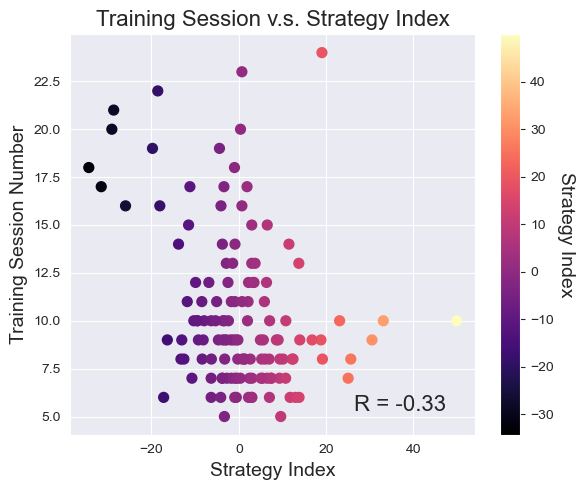

In [172]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_34_df['session_number'], training_34_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_34_df.strategy_index, 
                     y=training_34_df.session_number, 
                     c=training_34_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

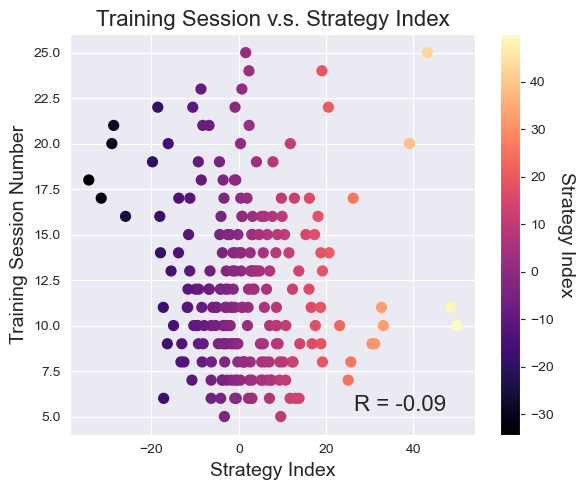

In [174]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_345_df['session_number'], training_345_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_345_df.strategy_index, 
                     y=training_345_df.session_number, 
                     c=training_345_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

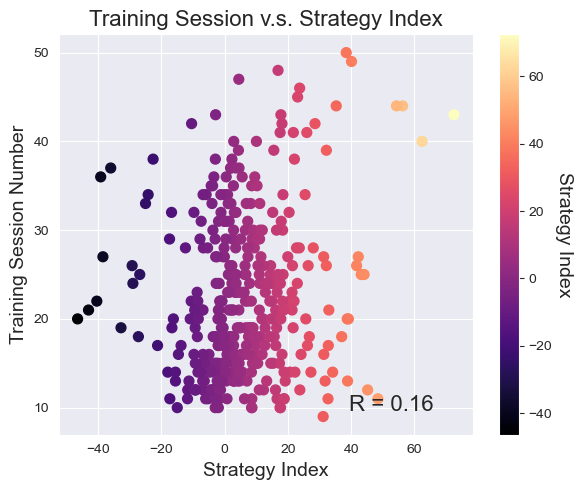

In [170]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_5_df['session_number'], training_5_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_5_df.strategy_index, 
                     y=training_5_df.session_number, 
                     c=training_5_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

In [ ]:
srategy_df_5_epi_merged

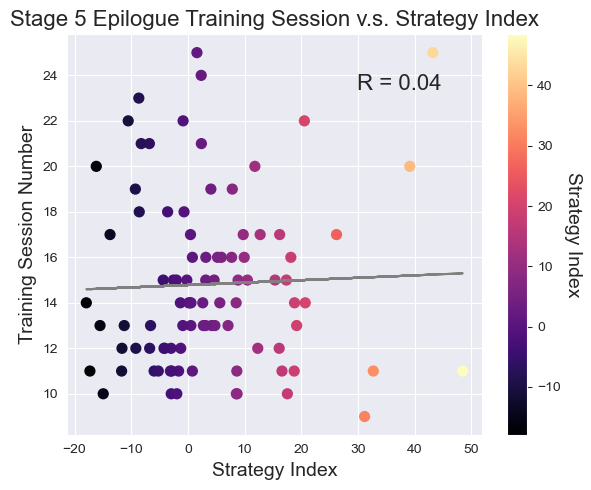

In [290]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(srategy_df_5_epi_merged['session_number'], srategy_df_5_epi_merged['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=srategy_df_5_epi_merged.strategy_index, 
                     y=srategy_df_5_epi_merged.session_number, 
                     c=srategy_df_5_epi_merged.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

slope, intercept, r_value, p_value, std_err = stats.linregress(srategy_df_5_epi_merged.strategy_index, srategy_df_5_epi_merged.session_number)
line = slope * srategy_df_5_epi_merged.strategy_index + intercept
ax.plot(srategy_df_5_epi_merged.strategy_index, line, color='grey', label='Regression Line')

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Stage 5 Epilogue Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.90, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

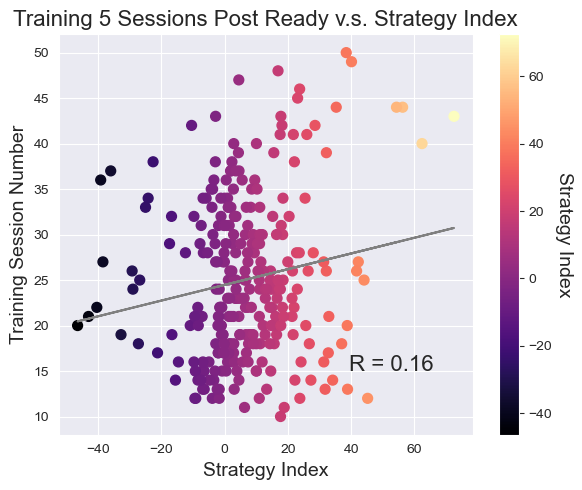

In [293]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_5_post_df['session_number'], training_5_post_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_5_post_df.strategy_index, 
                     y=training_5_post_df.session_number, 
                     c=training_5_post_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

# Calculate and plot regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(training_5_post_df.strategy_index, training_5_post_df.session_number)
line = slope * training_5_post_df.strategy_index + intercept
ax.plot(training_5_post_df.strategy_index, line, color='grey',label='Regression Line')

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training 5 Sessions Post Ready v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.20, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

In [182]:
# Sort the DataFrame by mouse_id and session_number in descending order
training_5_post_df_sorted = training_5_df.sort_values(['mouse_id', 'session_number'], ascending=[True, False])

# Group by mouse_id and select the top 2 rows for each group
training_5_post_latest_two = training_5_post_df_sorted.groupby('mouse_id').head(2).reset_index(drop=True)

# Print information about the original and resulting DataFrames
print(f"Original DataFrame shape: {training_5_post_df.shape}")
print(f"Latest two sessions DataFrame shape: {training_5_post_latest_two.shape}")

# Optional: Check if all mice have at least two sessions
mice_session_counts = training_5_post_latest_two['mouse_id'].value_counts()
mice_with_one_session = mice_session_counts[mice_session_counts == 1].index.tolist()

if mice_with_one_session:
    print(f"Note: The following mice have only one session in the result: {mice_with_one_session}")
else:
    print("All mice in the result have two sessions.")

# Display the first few rows of the result
print("\nFirst few rows of the resulting DataFrame:")
print(training_5_post_latest_two.head())

Original DataFrame shape: (290, 8)
Latest two sessions DataFrame shape: (54, 8)
All mice in the result have two sessions.

First few rows of the resulting DataFrame:
        auc          evd  visual_index  timing_index  strategy_index  \
0  0.783889  -731.812916     38.908493      0.467441       38.441052   
1  0.819315  -762.170090     40.670853      0.564109       40.106744   
2  0.815313 -1125.703091     24.068886      5.611898       18.456987   
3  0.794860 -1396.643418     13.738624      5.478539        8.260085   
4  0.874346  -880.531732     13.222732     11.147075        2.075657   

   mouse_id  session_number    stage  
0    524760              50  5_ready  
1    524760              49  5_ready  
2    524761              34  5_ready  
3    524761              33  5_ready  
4    531237              37  5_ready  


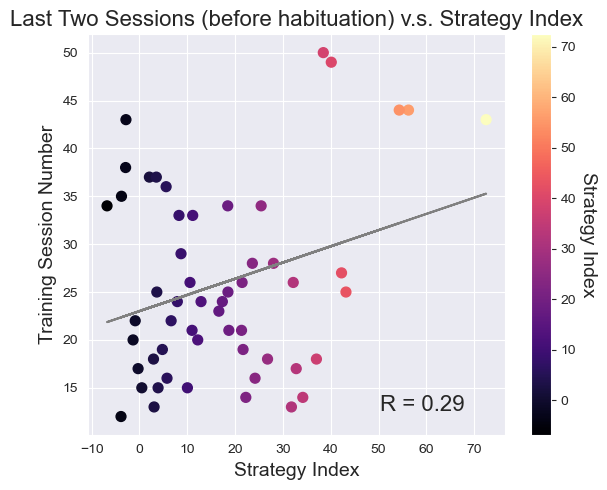

In [295]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_5_post_latest_two['session_number'], training_5_post_latest_two['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_5_post_latest_two.strategy_index, 
                     y=training_5_post_latest_two.session_number, 
                     c=training_5_post_latest_two.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 
# Calculate and plot regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(training_5_post_latest_two.strategy_index, training_5_post_latest_two.session_number)
line = slope * training_5_post_latest_two.strategy_index + intercept
ax.plot(training_5_post_latest_two.strategy_index, line, color='grey',label='Regression Line')


cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Last Two Sessions (before habituation) v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

In [309]:
ephys_df = pd.read_csv('local_modelfit/ephys/strategy_summary.csv')
subset_sessions = behavior_sessions[
    (behavior_sessions.session_type.str.contains('EPHYS')) & 
    (behavior_sessions.genotype == 'wt/wt')
]
ephys_df['mouse_id'] = subset_sessions.mouse_id.to_list()

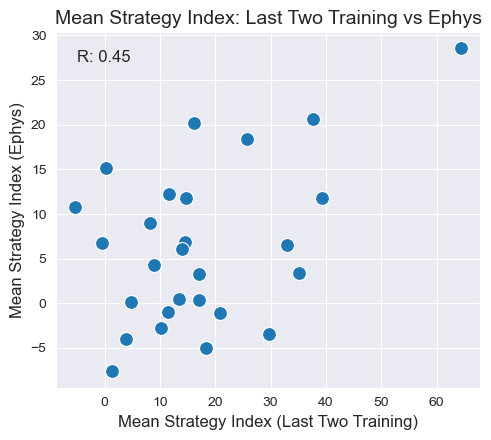

In [328]:
# Calculate mean strategy_index for each mouse_id in ephys_df
ephys_mean = ephys_df.groupby('mouse_id')['strategy_index'].mean()

# Calculate mean strategy_index for each mouse_id in training_5_post_latest_two
training_mean = training_5_post_latest_two.groupby('mouse_id')['strategy_index'].mean()

# Merge the two series on mouse_id
merged_means = pd.merge(ephys_mean, training_mean, on='mouse_id', suffixes=('_ephys', '_training'))

# Calculate the correlation
correlation = merged_means['strategy_index_ephys'].corr(merged_means['strategy_index_training'])

# Create a scatter plot
plt.figure(figsize=(5, 4.5))
sns.scatterplot(x='strategy_index_training', y='strategy_index_ephys', data=merged_means, s=100)
plt.xlabel('Mean Strategy Index (Last Two Training)', fontsize=12)
plt.ylabel('Mean Strategy Index (Ephys)', fontsize=12)
plt.title('Mean Strategy Index: Last Two Training vs Ephys', fontsize=14)

# Add correlation text
plt.text(0.05, 0.95, f'R: {correlation:.2f}', transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=12)

plt.tight_layout()
plt.show()

In [146]:
session_df = training_df

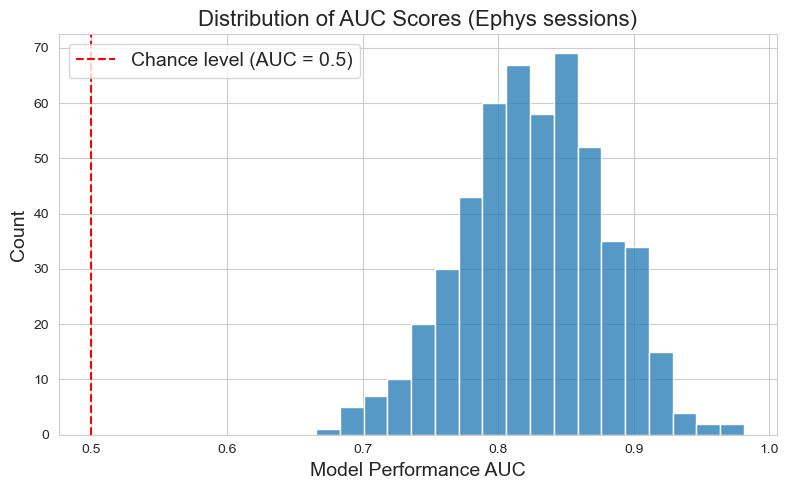

In [152]:
# AUC plot

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = [8, 5])
sns.histplot(session_df.auc)
ax.axvline(x=0.5, color='red', linestyle='--', label='Chance level (AUC = 0.5)')

plt.title('Distribution of AUC Scores (Ephys sessions)', fontsize=16)
plt.xlabel('Model Performance AUC', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()

In [147]:
# Calculate the average strategy index for each mouse
mouse_avg = session_df.groupby('mouse_id')['strategy_index'].mean().sort_values()
# Create a dictionary mapping mouse_id to average strategy index
mouse_avg_dict = mouse_avg.to_dict()
# Add a new column with the average strategy index for each mouse
session_df['avg_strategy_index'] = session_df['mouse_id'].map(mouse_avg_dict)
# Sort the DataFrame by the average strategy index
session_df_sorted_by_avg = session_df.sort_values('avg_strategy_index')

/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_89027/617004591.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('magma')


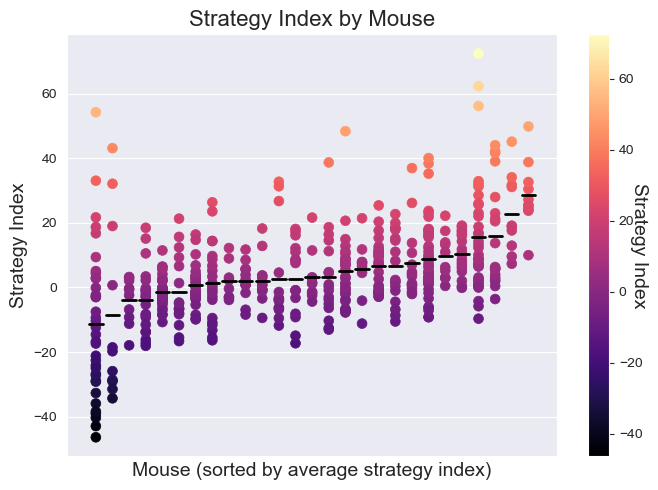

In [148]:
fig, ax = plt.subplots(figsize=(7, 5))

unique_mice = session_df_sorted_by_avg['mouse_id'].unique()

palette = plt.cm.get_cmap('magma')

norm = plt.Normalize(session_df_sorted_by_avg['strategy_index'].min(), 
                     session_df_sorted_by_avg['strategy_index'].max())

for i, mouse in enumerate(unique_mice):
    mouse_data = session_df_sorted_by_avg[session_df_sorted_by_avg['mouse_id'] == mouse]
    scatter = ax.scatter([i] * len(mouse_data), mouse_data['strategy_index'], 
                         c=mouse_data['strategy_index'], cmap=palette, norm=norm,
                         s=50, edgecolor=None, linewidth=0.5)


for i, mouse in enumerate(unique_mice):
    avg_index = mouse_avg[mouse]
    ax.plot([i-0.4, i+0.4], [avg_index, avg_index], color='black', linewidth=2)

ax.set_xlabel('Mouse (sorted by average strategy index)', fontsize=14)
ax.set_ylabel('Strategy Index', fontsize=14)
ax.set_title('Strategy Index by Mouse', fontsize=16)
ax.set_xticks([])  

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Strategy Index', rotation=270, fontsize = 14)

plt.tight_layout()
plt.show()

In [149]:
session_df_sorted_by_avg['session_number'].max()

50

/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_89027/3275178281.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('viridis')


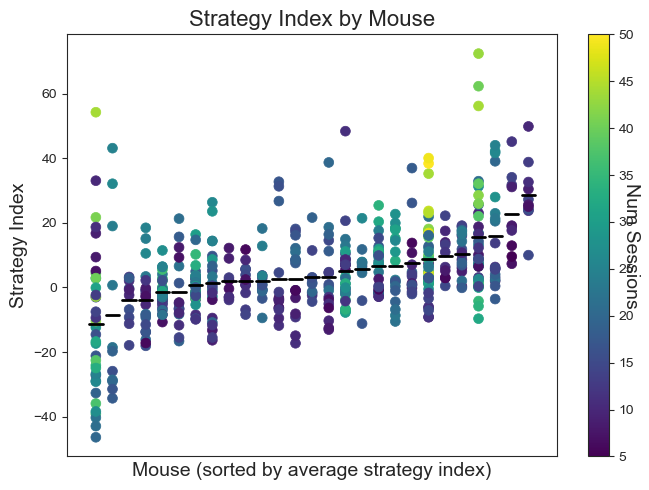

In [244]:
fig, ax = plt.subplots(figsize=(7, 5))

unique_mice = session_df_sorted_by_avg['mouse_id'].unique()

palette = plt.cm.get_cmap('viridis')

norm = plt.Normalize(session_df_sorted_by_avg['session_number'].min(), 
                     session_df_sorted_by_avg['session_number'].max())


for i, mouse in enumerate(unique_mice):
    mouse_data = session_df_sorted_by_avg[session_df_sorted_by_avg['mouse_id'] == mouse]
    scatter = ax.scatter([i] * len(mouse_data), mouse_data['strategy_index'], 
                         c=mouse_data['session_number'], norm = norm, cmap = palette,
                         s=50, edgecolor=None, linewidth=0.5)

for i, mouse in enumerate(unique_mice):
    avg_index = mouse_avg[mouse]
    ax.plot([i-0.4, i+0.4], [avg_index, avg_index], color='black', linewidth=2)

ax.set_xlabel('Mouse (sorted by average strategy index)', fontsize=14)
ax.set_ylabel('Strategy Index', fontsize=14)
ax.set_title('Strategy Index by Mouse', fontsize=16)
ax.set_xticks([]) 

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Num Sessions', rotation=270, fontsize = 14)

plt.tight_layout()
plt.show()

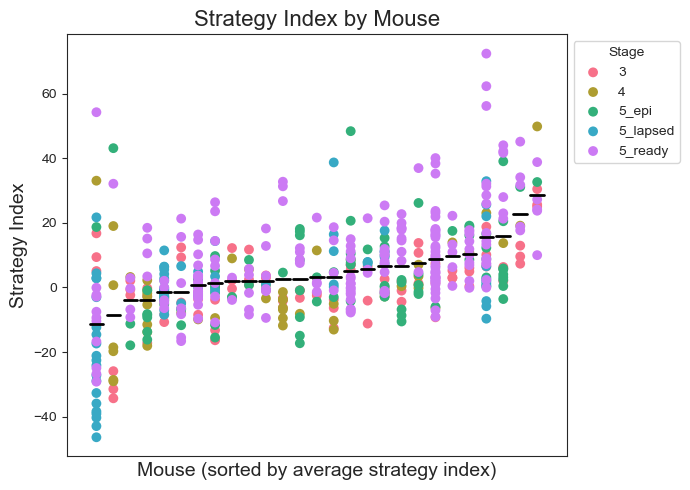

In [252]:
unique_stages = np.unique(np.concatenate([session_df_sorted_by_avg['stage'].unique(), training_df['stage'].unique()]))
color_palette = sns.color_palette("husl", n_colors=len(unique_stages))
stage_colors = dict(zip(unique_stages, color_palette))

fig, ax = plt.subplots(figsize=(7, 5))

unique_mice = session_df_sorted_by_avg['mouse_id'].unique()

for i, mouse in enumerate(unique_mice):
    mouse_data = session_df_sorted_by_avg[session_df_sorted_by_avg['mouse_id'] == mouse]
    for stage in unique_stages:
        stage_data = mouse_data[mouse_data['stage'] == stage]
        ax.scatter([i] * len(stage_data), stage_data['strategy_index'], 
                   c=[stage_colors[stage]], label=stage if i == 0 else "", 
                   s=50, edgecolor='none')

for i, mouse in enumerate(unique_mice):
    avg_index = mouse_avg[mouse]
    ax.plot([i-0.4, i+0.4], [avg_index, avg_index], color='black', linewidth=2)

ax.set_xlabel('Mouse (sorted by average strategy index)', fontsize=14)
ax.set_ylabel('Strategy Index', fontsize=14)
ax.set_title('Strategy Index by Mouse', fontsize=16)
ax.set_xticks([]) 

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Stage', 
          loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

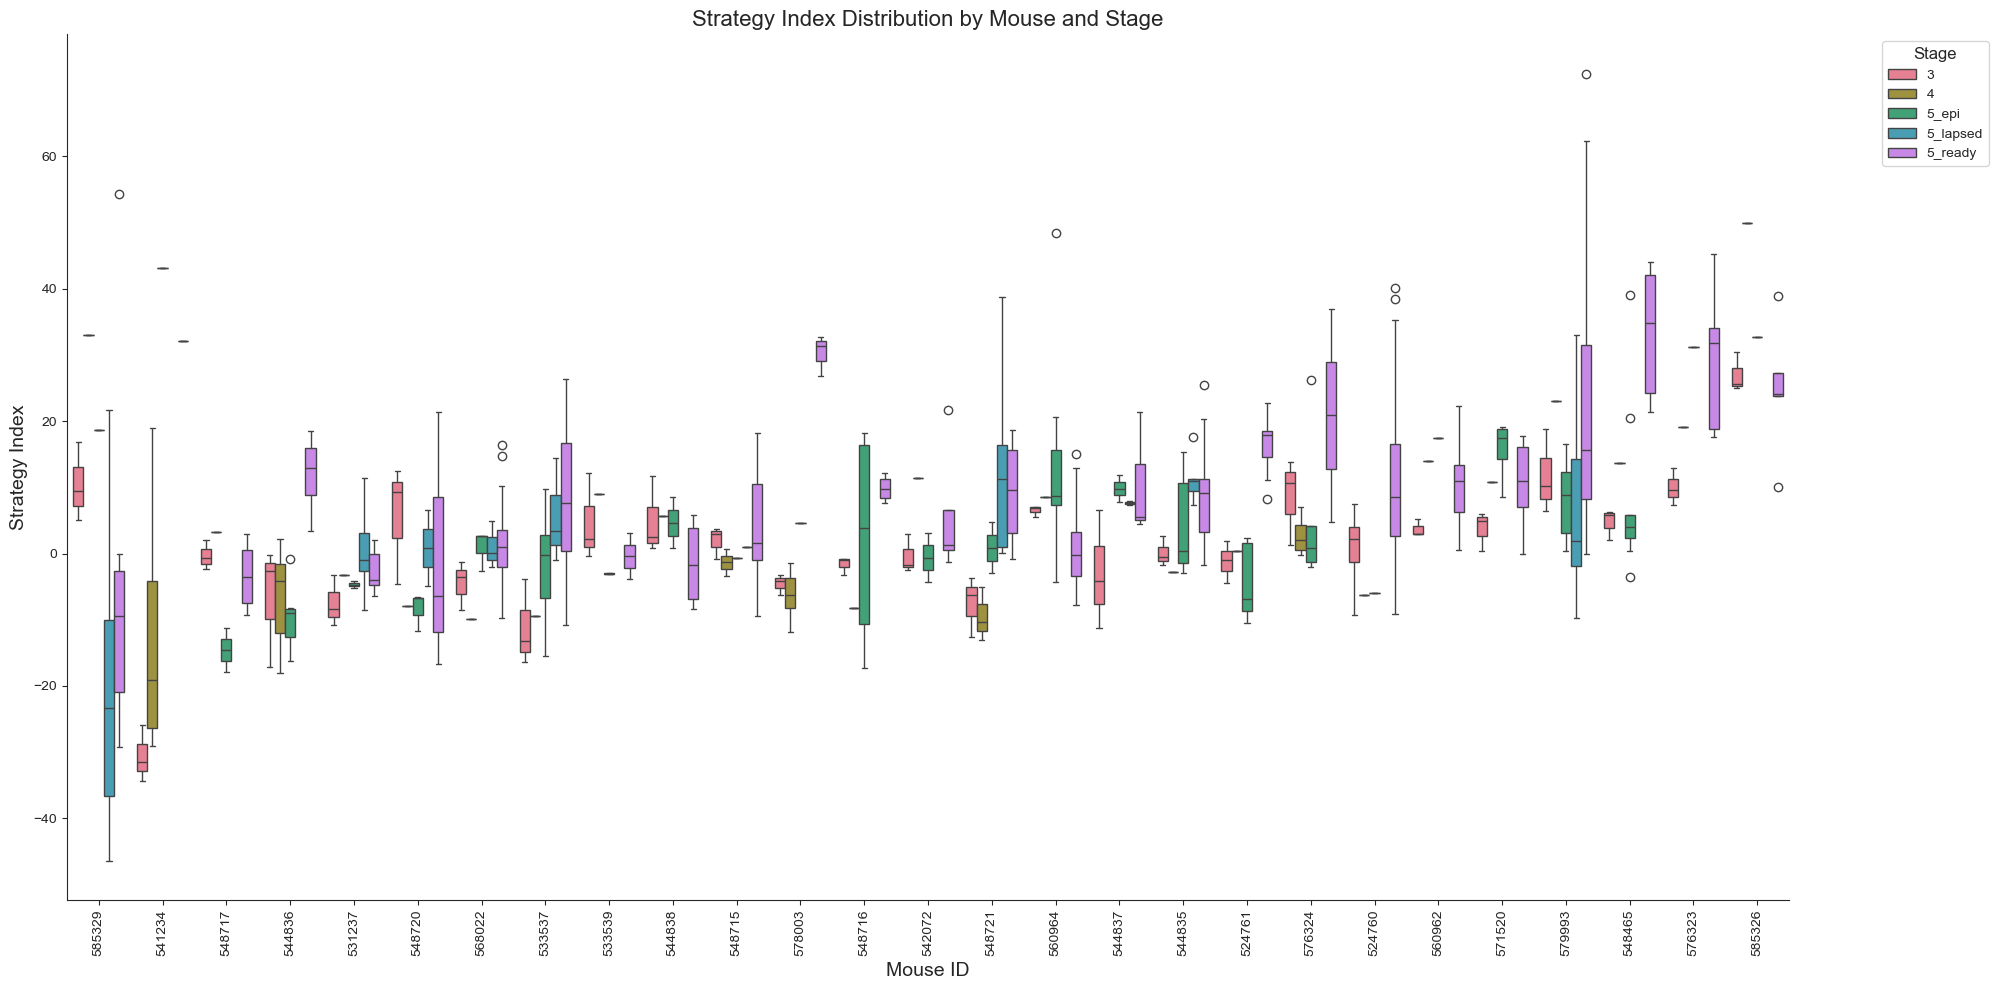

In [253]:
unique_stages = ['3', '4', '5_epi', '5_lapsed', '5_ready'] # Somehow my color dict order got messed up here
color_palette = sns.color_palette("husl", n_colors=len(unique_stages))
stage_colors = dict(zip(unique_stages, color_palette))

plot_data = session_df_sorted_by_avg.reset_index()

# Calculate the mean strategy index for each mouse to sort them
mouse_mean_strategy = plot_data.groupby('mouse_id')['strategy_index'].mean().sort_values(ascending=True)

# Create a categorical mouse_id column for proper ordering
plot_data['mouse_id_cat'] = pd.Categorical(plot_data['mouse_id'], categories=mouse_mean_strategy.index, ordered=True)

# Create a categorical stage column for proper ordering
plot_data['stage_cat'] = pd.Categorical(plot_data['stage'], categories=unique_stages, ordered=True)

plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='mouse_id_cat', y='strategy_index', hue='stage_cat', data=plot_data,
                 palette=stage_colors, dodge=True, order=mouse_mean_strategy.index, hue_order=unique_stages)

plt.xlabel('Mouse ID', fontsize=14)
plt.ylabel('Strategy Index', fontsize=14)
plt.title('Strategy Index Distribution by Mouse and Stage', fontsize=16)

plt.xticks(rotation=90)

plt.legend(title='Stage', title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

sns.despine()

plt.tight_layout()
plt.show()

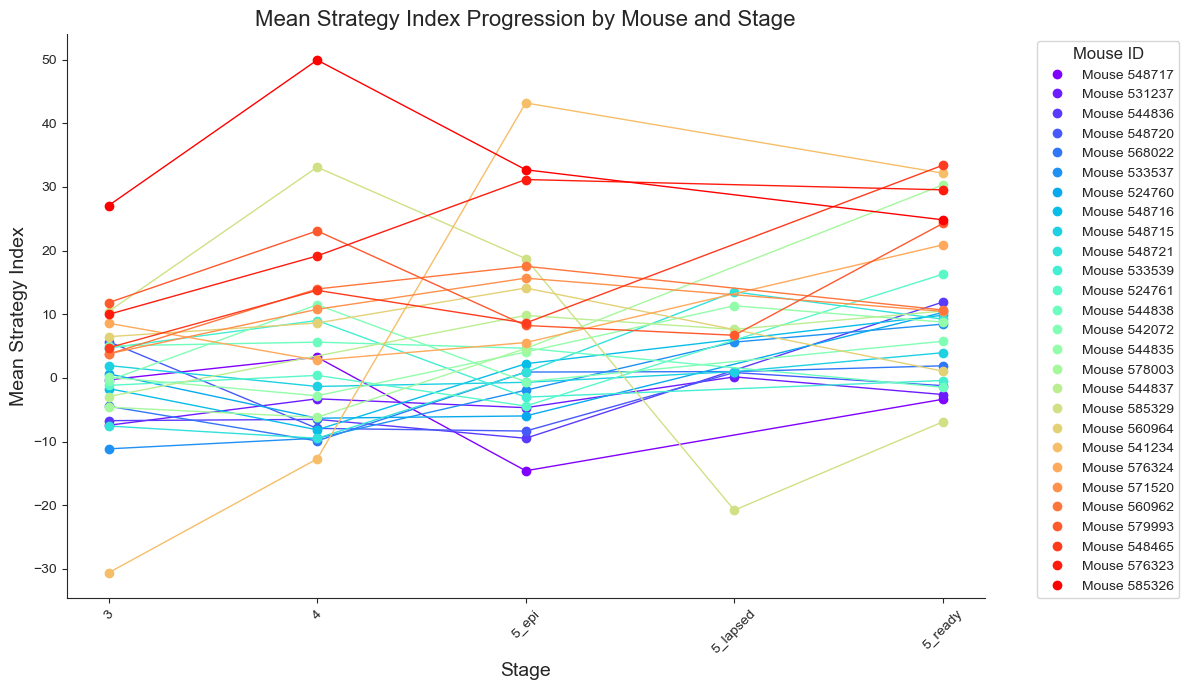

In [263]:
plot_data = session_df_sorted_by_avg.reset_index()

# Calculate the mean strategy index for each mouse and stage
mean_data = plot_data.groupby(['mouse_id', 'stage'])['strategy_index'].mean().unstack()

# Sort mice by their overall mean strategy index
mouse_order = mean_data.mean(axis=1).sort_values().index

unique_stages = ['3', '4', '5_epi', '5_lapsed', '5_ready']

# Mouse color palette
mouse_colors = plt.cm.rainbow(np.linspace(0, 1, len(mouse_order)))

plt.figure(figsize=(12, 7))

for mouse, color in zip(mouse_order, mouse_colors):
    mouse_data = mean_data.loc[mouse]
    
    # Plot lines and markers for non-NaN values
    plt.plot(unique_stages, mouse_data[unique_stages], marker='o', linestyle='', color=color, label=f'Mouse {mouse}')
    
    # Connect points, skipping NaN values
    valid_stages = [stage for stage in unique_stages if not pd.isna(mouse_data[stage])]
    plt.plot(valid_stages, mouse_data[valid_stages], linestyle='-', linewidth=1, color=color)

plt.xlabel('Stage', fontsize=14)
plt.ylabel('Mean Strategy Index', fontsize=14)
plt.title('Mean Strategy Index Progression by Mouse and Stage', fontsize=16)

plt.xticks(rotation=45)

plt.legend(title='Mouse ID', title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

sns.despine()

plt.tight_layout()
plt.show()

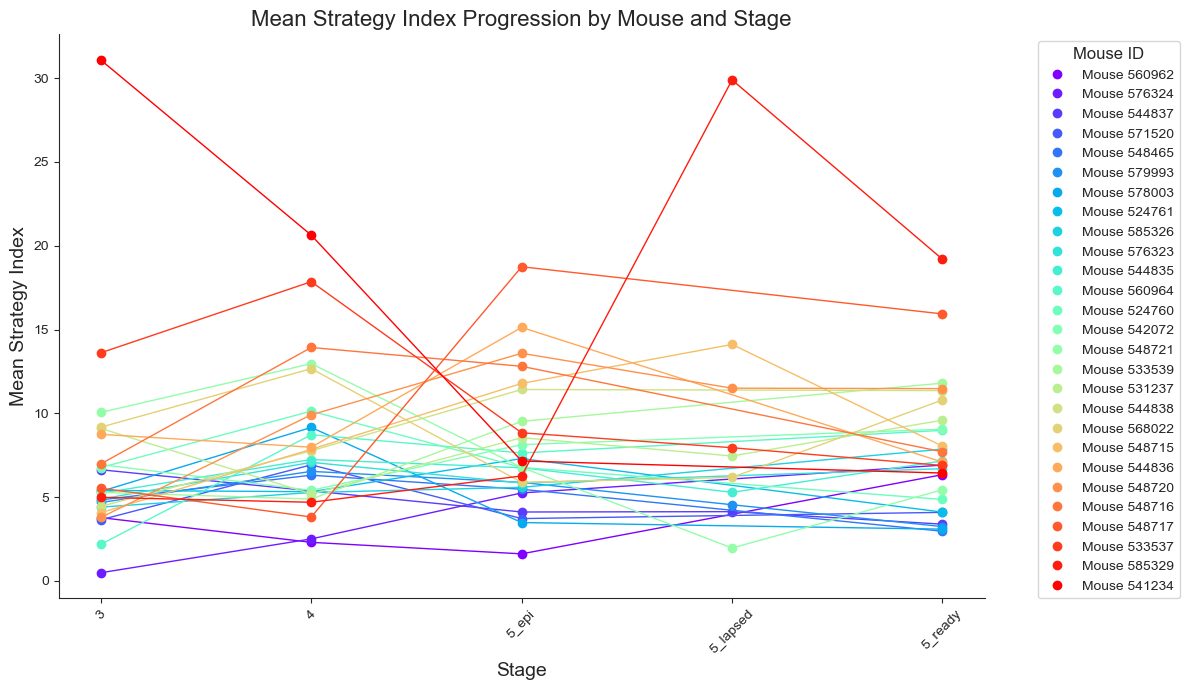

In [266]:
plot_data = session_df_sorted_by_avg.reset_index()

# Calculate the mean strategy index for each mouse and stage
mean_data = plot_data.groupby(['mouse_id', 'stage'])['timing_strategy'].mean().unstack()

# Sort mice by their overall mean strategy index
mouse_order = mean_data.mean(axis=1).sort_values().index

unique_stages = ['3', '4', '5_epi', '5_lapsed', '5_ready']

# Mouse color palette
mouse_colors = plt.cm.rainbow(np.linspace(0, 1, len(mouse_order)))

plt.figure(figsize=(12, 7))

for mouse, color in zip(mouse_order, mouse_colors):
    mouse_data = mean_data.loc[mouse]
    
    # Plot lines and markers for non-NaN values
    plt.plot(unique_stages, mouse_data[unique_stages], marker='o', linestyle='', color=color, label=f'Mouse {mouse}')
    
    # Connect points, skipping NaN values
    valid_stages = [stage for stage in unique_stages if not pd.isna(mouse_data[stage])]
    plt.plot(valid_stages, mouse_data[valid_stages], linestyle='-', linewidth=1, color=color)

plt.xlabel('Stage', fontsize=14)
plt.ylabel('Mean Timing Strategy Index', fontsize=14)
plt.title('Mean Timing Strategy Index Progression by Mouse and Stage', fontsize=16)

plt.xticks(rotation=45)

plt.legend(title='Mouse ID', title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

sns.despine()

plt.tight_layout()
plt.show()

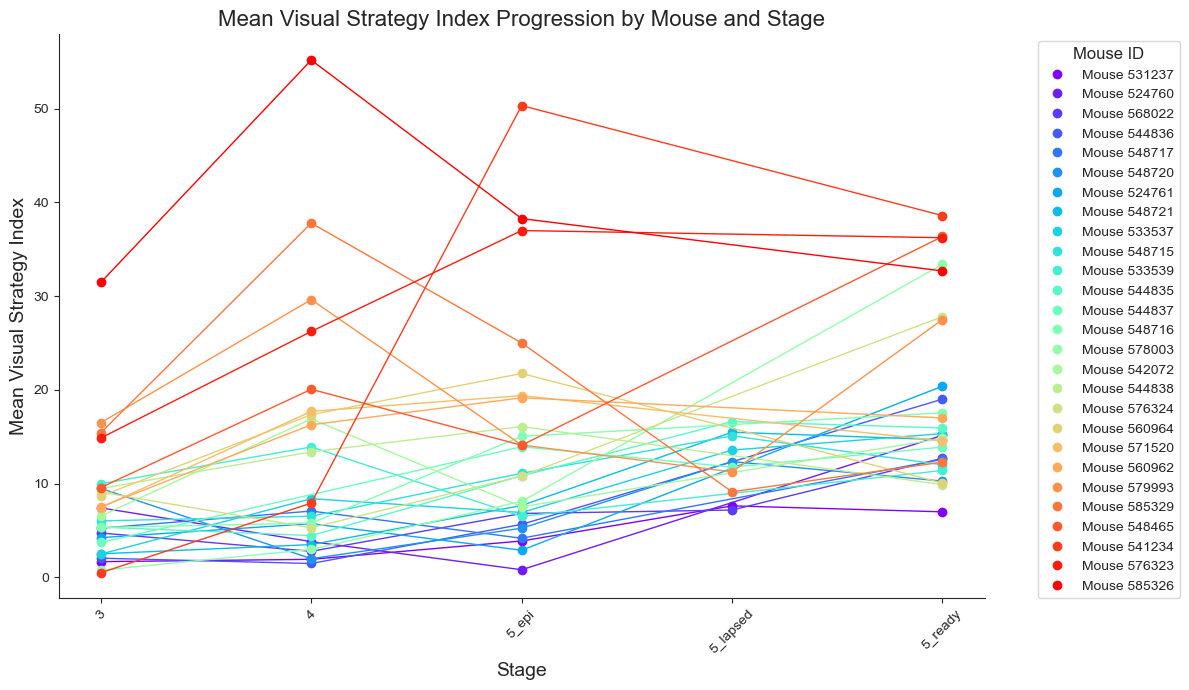

In [268]:
# Prepare the data
plot_data = session_df_sorted_by_avg.reset_index()

# Calculate the mean strategy index for each mouse and stage
mean_data = plot_data.groupby(['mouse_id', 'stage'])['visual_index'].mean().unstack()

# Sort mice by their overall mean strategy index
mouse_order = mean_data.mean(axis=1).sort_values().index

# Define stages
unique_stages = ['3', '4', '5_epi', '5_lapsed', '5_ready']

# Create a color palette for mice
mouse_colors = plt.cm.rainbow(np.linspace(0, 1, len(mouse_order)))

# Create the plot
plt.figure(figsize=(12, 7))

for mouse, color in zip(mouse_order, mouse_colors):
    mouse_data = mean_data.loc[mouse]
    
    # Plot lines and markers for non-NaN values
    plt.plot(unique_stages, mouse_data[unique_stages], marker='o', linestyle='', color=color, label=f'Mouse {mouse}')
    
    # Connect points, skipping NaN values
    valid_stages = [stage for stage in unique_stages if not pd.isna(mouse_data[stage])]
    plt.plot(valid_stages, mouse_data[valid_stages], linestyle='-', linewidth=1, color=color)

# Customize the plot
plt.xlabel('Stage', fontsize=14)
plt.ylabel('Mean Visual Strategy Index', fontsize=14)
plt.title('Mean Visual Strategy Index Progression by Mouse and Stage', fontsize=16)

# Adjust x-axis
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Mouse ID', title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()